##### The goal of this project is to build a machine learning model to predict the event outcome (booking or just a click) for a user event, based on their search and other attributes associated with that user event.

### Import Libraries

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

To be able to process locally, we will use 1% of the data. Even after that we shall 241,179 records.

In [2]:
df = pd.read_csv('train.csv', sep=',').dropna()
df = df.sample(frac=0.01, random_state=99)

In [3]:
df.shape

(241179, 24)

In [4]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
32352134,2014-05-22 11:40:07,2,3,66,174,24103,2323.5232,802499,0,1,...,0,1,1442,3,0,1,4,125,177,44
29796021,2013-06-29 12:24:37,2,3,66,311,25538,2288.6121,85229,0,0,...,1,1,8272,1,0,1,2,50,659,59
15185156,2014-10-30 13:58:32,2,3,66,294,40046,587.6970,755217,0,1,...,0,1,11321,1,0,1,2,50,642,22
3301948,2014-08-22 20:14:34,2,3,66,332,55121,2234.4394,160733,0,1,...,0,1,1152,1,1,1,4,47,1502,65
25429119,2014-03-25 18:47:43,2,3,66,314,47869,839.0087,1078493,0,0,...,0,1,8284,1,0,4,2,50,685,6


### Feature engineering

This involves converting the columns date_time, srch_ci and srch_co to datetime format and creating new columns to improve our analysis such as year,month and plan_time.
We will also remove the columns not needed.

In [5]:
df["date_time"] = pd.to_datetime(df["date_time"]) 
df["year"] = df["date_time"].dt.year  
df["month"] = df["date_time"].dt.month
df['srch_ci']=pd.to_datetime(df['srch_ci'],infer_datetime_format = True,errors='coerce')
df['srch_co']=pd.to_datetime(df['srch_co'],infer_datetime_format = True,errors='coerce')
df['plan_time'] = ((df['srch_ci']-df['date_time'])/np.timedelta64(1,'D')).astype(float)
df['hotel_nights']=((df['srch_co']-df['srch_ci'])/np.timedelta64(1,'D')).astype(float)
cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'user_id']
df.drop(cols_to_drop, axis=1, inplace=True)

### Plot a Correlation Matrix to understand the correlation between features

Text(0.5, 1, 'Correlation between different fearures')

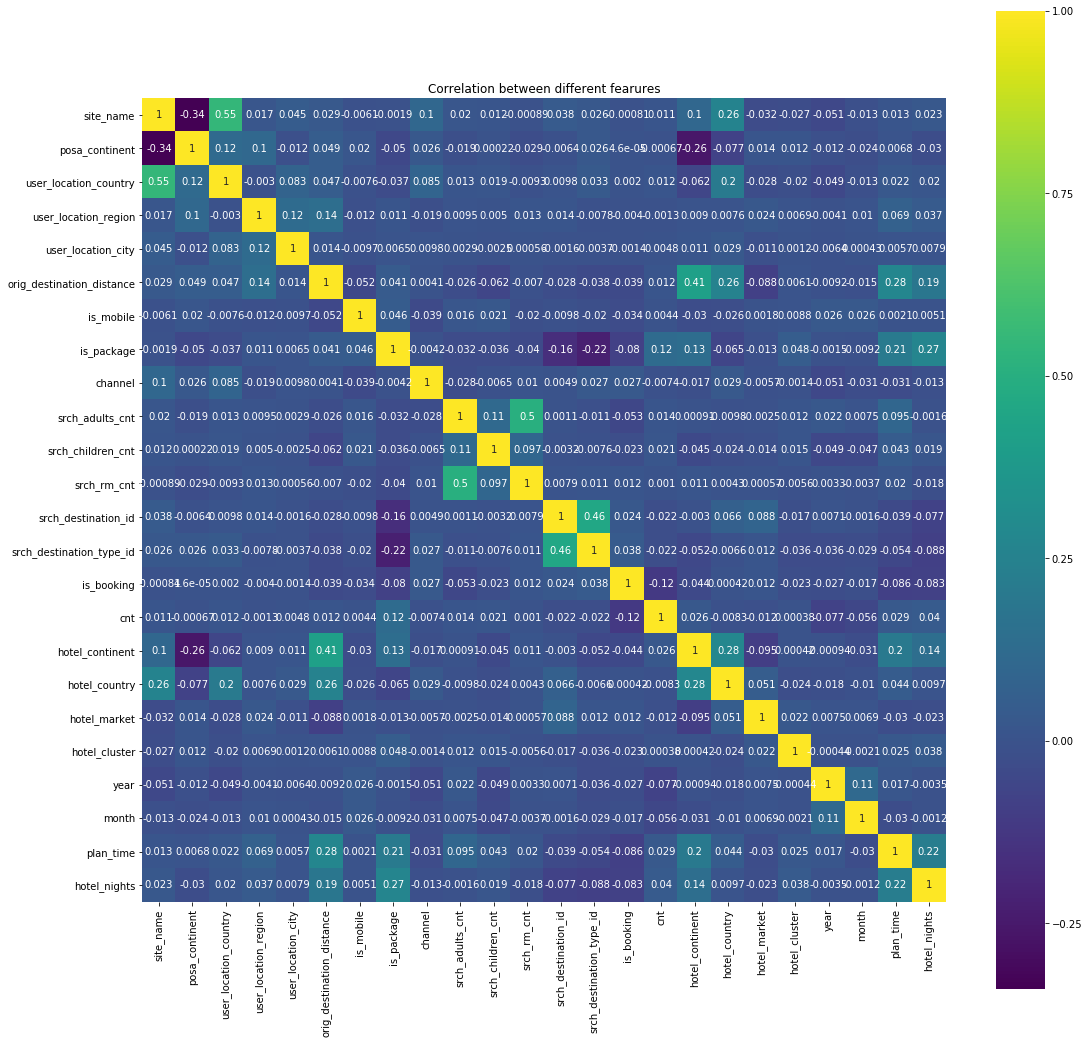

In [6]:
correlation = df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different fearures')

We see that no two varibles are closely related

### Check if data is imbalanced

Text(0, 0.5, 'Frequency')

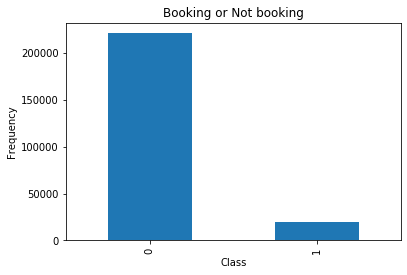

In [7]:
count_classes = pd.value_counts(df['is_booking'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Booking or Not booking")
plt.xlabel("Class")
plt.ylabel("Frequency")

We see that the dataset is highly imbalanced. We shall use under sampling to deal with it

In [8]:
booking_indices = df[df.is_booking == 1].index
random_indices = np.random.choice(booking_indices, len(df.loc[df.is_booking == 1]), replace=False)
booking_sample = df.loc[random_indices]
not_booking = df[df.is_booking == 0].index
random_indices = np.random.choice(not_booking, sum(df['is_booking']), replace=False)
not_booking_sample = df.loc[random_indices]
df_new = pd.concat([not_booking_sample, booking_sample], axis=0)
print("Percentage of not booking clicks: ", len(df_new[df_new.is_booking == 0])/len(df_new))
print("Percentage of booking clicks: ", len(df_new[df_new.is_booking == 1])/len(df_new))
print("Total number of records in resampled data: ", len(df_new))

Percentage of not booking clicks:  0.5
Percentage of booking clicks:  0.5
Total number of records in resampled data:  40064


### Shuffle the resampled dataframe.

In [9]:
df_new = df_new.sample(frac=1).reset_index(drop=True)

### Assign features and label for the new dataframe.

In [10]:
X = df_new.loc[:, df_new.columns != 'is_booking']
y = df_new.loc[:, df_new.columns == 'is_booking']

### PCA

#### Standardize dataset

In [11]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
X

array([[-0.46509245,  0.18121667, -0.4064888 , ...,  1.21040253,
        -0.12970659,  1.65986537],
       [-0.46509245,  0.18121667, -0.4064888 , ...,  1.51475419,
        -0.56656787, -0.73719498],
       [-0.46509245,  0.18121667, -0.4064888 , ...,  1.51475419,
        -0.51710539,  0.4613352 ],
       ...,
       [ 0.52738663,  0.18121667,  2.13637031, ...,  1.21040253,
         0.63146881, -0.73719498],
       [-0.46509245,  0.18121667, -0.4064888 , ..., -0.0070041 ,
        -0.64628624, -0.73719498],
       [ 1.85069206, -3.5903493 , -1.59559558, ...,  0.29734756,
        -0.71814094, -0.73719498]])

#### Apply PCA

In [12]:
pca = PCA(n_components=23)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

#### Calculate Eigenvalues

In [13]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

array([  9.5,  17.7,  24.5,  30.8,  36.4,  41.6,  46.5,  51.1,  55.6,
        60. ,  64.2,  68.3,  72.4,  76.4,  80.3,  84. ,  87.2,  90. ,
        92.5,  94.8,  96.9,  98.8, 100.1])

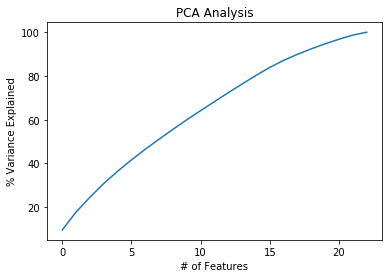

In [14]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(var)

From the above plot, it is clear we should use all the 23 features we have in our dataset

### Build Model, Predict and Evaluate

#### Random Forest Classifier 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
pca = PCA()  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)
classifier = RandomForestClassifier(max_depth=2, random_state=0)  
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[[3344 2645]
 [2029 4002]]
Accuracy 0.6111480865224626


#### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
pca = PCA(n_components=23)
logReg = LogisticRegression()
pipe = Pipeline([('pca', pca), ('logistic', logReg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[3294 2695]
 [1110 4921]]
Accuracy 0.6834442595673876
